<a href="https://colab.research.google.com/github/syedhadi816/AI-Influenced-Speech-Detection/blob/main/AI_Influenced_Speech_Detection_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install librosa praat-parselmouth textstat scipy pandas nltk spacy transformers torchaudio
#import nltk
#nltk.download('punkt')  # Needed for tokenization

#import spacy
#spacy.cli.download("en_core_web_sm")  # For POS tagging, etc.


In [ ]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import scipy.stats
import textstat
import nltk
import parselmouth
from parselmouth.praat import call
import spacy
from nltk.tokenize import word_tokenize
from parselmouth.praat import call


In [ ]:
nlp = spacy.load("en_core_web_sm")

# --- Feature functions ---
def calculate_speech_rate(text, duration):
    words = len(text.split())
    return words / (duration / 60) if duration > 0 else 0

def calculate_pauses(y, sr):
    silence = librosa.effects.split(y, top_db=20)
    pause_durations = [(end - start) / sr for start, end in silence]
    total_pauses = sum(pause_durations)
    avg_pause_len = np.mean(pause_durations) if pause_durations else 0
    duration = librosa.get_duration(y=y, sr=sr)
    return total_pauses, (total_pauses / duration) * 60 if duration > 0 else 0, avg_pause_len

def calculate_tempo(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    return len(beats), tempo

def lexical_diversity(text):
    words = word_tokenize(text)
    return len(set(words)) / len(words) if words else 0

def linguistic_complexity(text):
    return {
        "syllable_count": textstat.syllable_count(text),
        "lexicon_count": textstat.lexicon_count(text),
        "readability_index": textstat.flesch_kincaid_grade(text)
    }

def calculate_intonation_range(y, sr):
    sound = parselmouth.Sound(y, sr)
    pitch = sound.to_pitch()
    values = pitch.selected_array['frequency']
    values = values[values > 0]
    return np.max(values) - np.min(values) if values.size > 0 else 0

def calculate_repetition_rate(text):
    words = word_tokenize(text)
    freq = nltk.FreqDist(words)
    repeated = sum(count > 1 for count in freq.values())
    return repeated / len(words) if words else 0

def calculate_word_emphasis(y):
    rms = librosa.feature.rms(y=y)
    return np.max(rms) - np.min(rms)

def calculate_pitch_variation(y, sr):
    sound = parselmouth.Sound(y, sr)
    pitch = sound.to_pitch()
    values = pitch.selected_array['frequency']
    return np.var(values[values > 0]) if values.size > 0 else 0

def calculate_articulation_rate(text, total_duration, pause_duration):
    words = len(text.split())
    effective_duration = total_duration - pause_duration
    return words / (effective_duration / 60) if effective_duration > 0 else 0

def calculate_energy_entropy(y):
    rms = librosa.feature.rms(y=y)
    return scipy.stats.entropy(rms.flatten())

def calculate_spectral_flux(y):
    stft = np.abs(librosa.stft(y))
    flux = np.sqrt(np.sum(np.diff(stft, axis=1) ** 2, axis=0))
    return np.mean(flux)


def calculate_filler_rate(text, fillers={"um", "uh", "like", "you know"}):
    words = word_tokenize(text.lower())
    return sum(word in fillers for word in words) / len(words) if words else 0

def calculate_syntactic_complexity(text):
    doc = nlp(text)
    clause_count = sum(1 for sent in doc.sents for token in sent if token.dep_ in {"advcl", "ccomp", "xcomp", "relcl"})
    sentence_count = len(list(doc.sents))
    return clause_count / sentence_count if sentence_count > 0 else 0





def extract_features(audio_path, transcript_path, label):
    features = []
    audio_files = glob.glob(os.path.join(audio_path, "*.wav")) #+ glob.glob(os.path.join(audio_path, "*.mp3"))

    for audio_file in audio_files:
        try:
            #print(f"Processing: {audio_file}")
            base = os.path.splitext(os.path.basename(audio_file))[0]
            transcript_file = os.path.join(transcript_path, base + ".txt")

            if not os.path.exists(transcript_file):
                print(f"Transcript not found for: {base}")
                continue

            with open(transcript_file, "r", encoding="utf-8") as f:
                transcript = f.read().strip()

            y, sr = librosa.load(audio_file)
            duration = librosa.get_duration(y=y, sr=sr)
            pause_total, pauses_per_minute, avg_pause = calculate_pauses(y, sr)
            beat_count, tempo = calculate_tempo(y, sr)
            ling = linguistic_complexity(transcript)

            row = {
                "filename": base,
                "label": label,
                "speech_rate": calculate_speech_rate(transcript, duration),
                "articulation_rate": calculate_articulation_rate(transcript, duration, pause_total),
                "lexical_diversity": lexical_diversity(transcript),
                "syllable_count": ling['syllable_count'],
                "lexicon_count": ling['lexicon_count'],
                "readability_index": ling['readability_index'],
                "intonation_range": calculate_intonation_range(y, sr),
                "pitch_variation": calculate_pitch_variation(y, sr),
                "repetition_rate": calculate_repetition_rate(transcript),
                "tempo": tempo,
                "beat_count": beat_count,
                "word_emphasis": calculate_word_emphasis(y),
                "energy_entropy": calculate_energy_entropy(y),
                "spectral_flux": calculate_spectral_flux(y),
                "pause_total": pause_total,
                "pauses_per_minute": pauses_per_minute,
                "avg_pause_length": avg_pause,
                "filler_word_rate": calculate_filler_rate(transcript),
                "syntactic_complexity": calculate_syntactic_complexity(transcript)
            }

            features.append(row)

        except Exception as e:
            print(f"Error processing {audio_file}: {e}")
            continue

    return pd.DataFrame(features)







# --- Run for all files ---
def build_dataset():
    plag_features = extract_features(
        r"C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\plagiarized_audio",
        r"C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\plagiarized_transcripts",
        label=1
    )
    control_features = extract_features(
        r"C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\control_audio",
        r"C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\control_transcripts",
        label=0
    )
    df = pd.concat([plag_features, control_features], ignore_index=True)
    return df


In [ ]:
df = build_dataset()
df['tempo'] = df['tempo'].apply(lambda x: x[0])
df = df.dropna()
#df = df.drop_duplicates(subset='filename', keep='first')

Error processing C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\plagiarized_audio\990628186870_20036.wav: 'utf-8' codec can't decode byte 0xf3 in position 65: invalid continuation byte
Error processing C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\plagiarized_audio\990628265414_20029.wav: 'utf-8' codec can't decode byte 0xe7 in position 9: invalid continuation byte


C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error processing C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\control_audio\990648009150 C91 T_BC 20029 TRS_10 RS_1.wav: 'utf-8' codec can't decode byte 0xe3 in position 40: invalid continuation byte
Error processing C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\control_audio\990648009150 C91 T_BC 20695 TRS_10 RS_3.wav: 'utf-8' codec can't decode byte 0xf1 in position 20: invalid continuation byte


Training Logistic Regression...
Logistic Regression Accuracy: 0.8672
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        77
           1       0.87      0.78      0.82        51

    accuracy                           0.87       128
   macro avg       0.87      0.85      0.86       128
weighted avg       0.87      0.87      0.87       128

Training Random Forest...
Random Forest Accuracy: 0.8906
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        77
           1       0.91      0.80      0.85        51

    accuracy                           0.89       128
   macro avg       0.90      0.88      0.88       128
weighted avg       0.89      0.89      0.89       128

Training XGBoost...
XGBoost Accuracy: 0.8516
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        77
           1       0.86      0.75      0.80        51

    accurac

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy: 0.8750
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        77
           1       0.87      0.80      0.84        51

    accuracy                           0.88       128
   macro avg       0.87      0.86      0.87       128
weighted avg       0.87      0.88      0.87       128

Training Naive Bayes...
Naive Bayes Accuracy: 0.6562
              precision    recall  f1-score   support

           0       0.84      0.53      0.65        77
           1       0.54      0.84      0.66        51

    accuracy                           0.66       128
   macro avg       0.69      0.69      0.66       128
weighted avg       0.72      0.66      0.66       128

Training CatBoost...
CatBoost Accuracy: 0.8672
              precision    recall  f1-score   support

           0       0.86      0.94      0.89        77
           1       0.89      0.76      0.82        51

    accuracy                           0.87       128
   macr

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


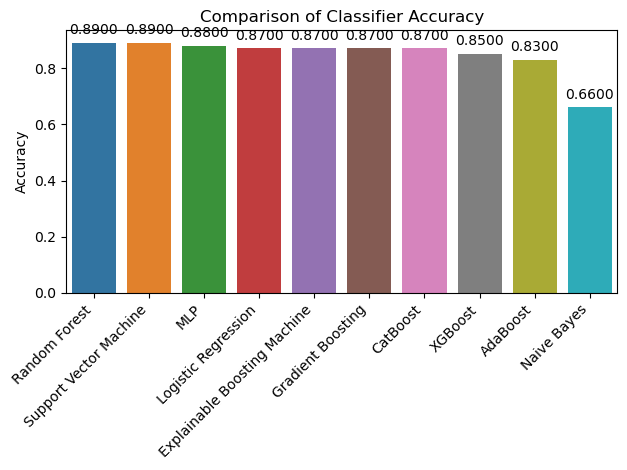

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import catboost
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['filename', 'label'])
y = df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test set (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(),
    "Explainable Boosting Machine": ExplainableBoostingClassifier(),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500),
    "Naive Bayes": GaussianNB(),
    "CatBoost": catboost.CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=False)
}

# Train and evaluate each classifier
results = {}
for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[clf_name] = {
        'Accuracy': accuracy,
        'Classification Report': report
    }
    print(f"{clf_name} Accuracy: {accuracy:.4f}")
    print(report)

# Sort results by accuracy
sorted_accuracies = dict(sorted({name: result['Accuracy'].round(2) for name, result in results.items()}.items(), key=lambda item: item[1], reverse=True))

# Plotting
sns.barplot(x=list(sorted_accuracies.keys()), y=list(sorted_accuracies.values()))
plt.title('Comparison of Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(sorted_accuracies.values()):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
sorted_accuracies

{'Support Vector Machine': 0.89,
 'Logistic Regression': 0.87,
 'Explainable Boosting Machine': 0.87,
 'Gradient Boosting': 0.87,
 'MLP': 0.87,
 'CatBoost': 0.87,
 'Random Forest': 0.86,
 'XGBoost': 0.85,
 'AdaBoost': 0.83,
 'Naive Bayes': 0.66}

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


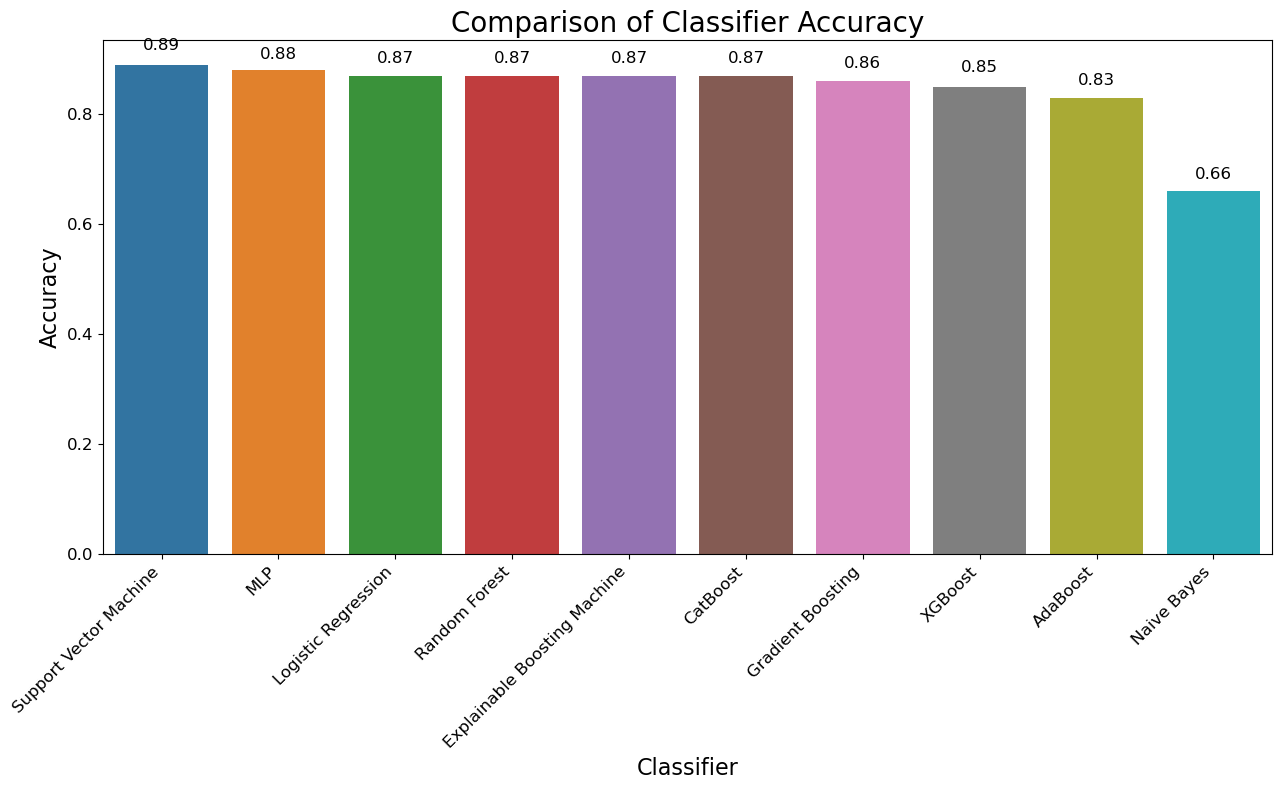

In [ ]:
# Sort results by accuracy
sorted_accuracies = dict(sorted({name: result['Accuracy'] for name, result in results.items()}.items(), key=lambda item: item[1], reverse=True))

# Plotting
plt.figure(figsize=(13, 8))
sns.barplot(x=list(sorted_accuracies.keys()), y=[round(v, 2) for v in sorted_accuracies.values()])
plt.title('Comparison of Classifier Accuracy', fontsize=20)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Classifier', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for i, v in enumerate(sorted_accuracies.values()):
    plt.text(i, v + 0.02, f"{round(v, 2):.2f}", ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.savefig(r"C:\Users\shadi\Desktop\NCME Proposal\classifier_results.png")
plt.show()


C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


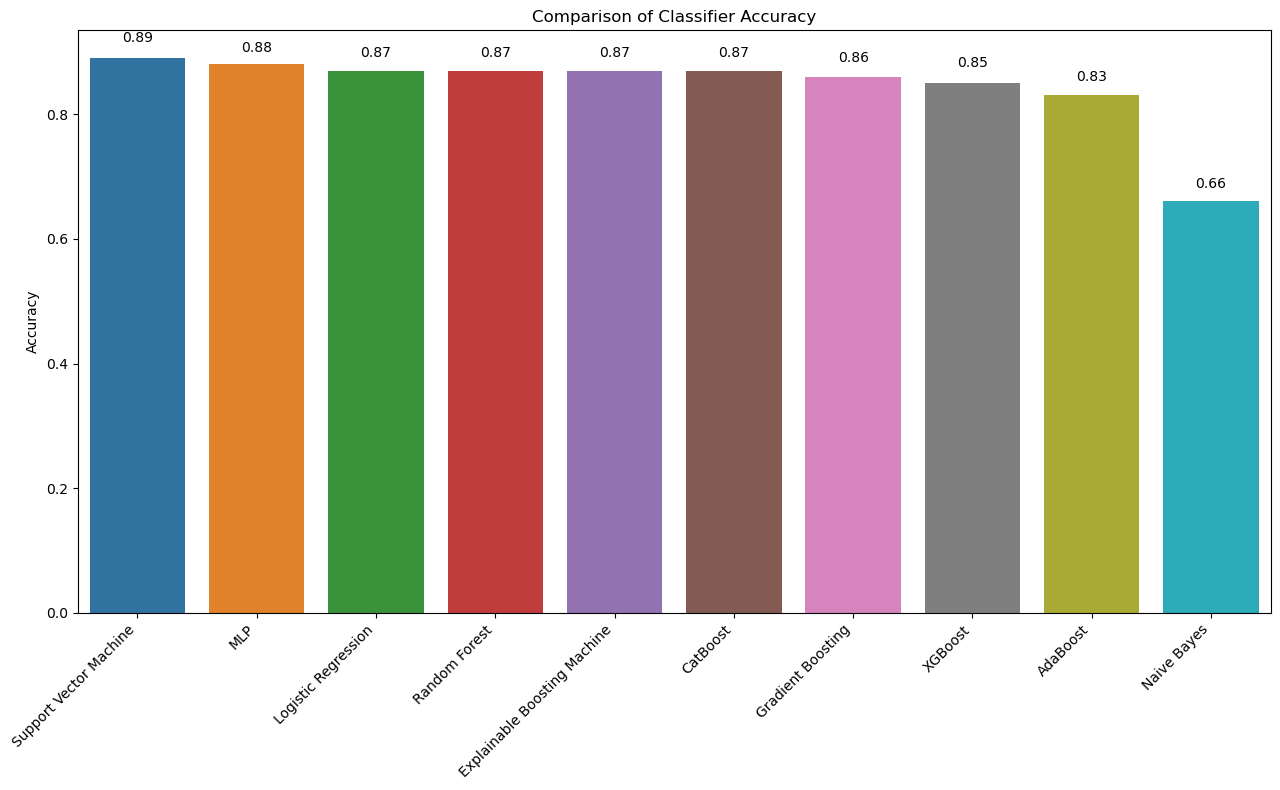

In [ ]:
# Sort results by accuracy
sorted_accuracies = dict(sorted({name: result['Accuracy'] for name, result in results.items()}.items(), key=lambda item: item[1], reverse=True))

# Plotting
plt.figure(figsize=(13, 8))  # Increased plot size
sns.barplot(x=list(sorted_accuracies.keys()), y=[round(v, 2) for v in sorted_accuracies.values()])
plt.title('Comparison of Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(sorted_accuracies.values()):
    plt.text(i, v + 0.02, f"{round(v, 2):.2f}", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig(r"C:\Users\shadi\Desktop\NCME Proposal\classifier_results.png")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_table = []

for clf_name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    metrics_table.append({
        'Model': clf_name,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3),
        'Accuracy': round(accuracy_score(y_test, y_pred), 3),
        'False Positive Rate': round(false_positive_rate, 2),
        'False Negative Rate': round(false_negative_rate, 2)
    })

metrics_df = pd.DataFrame(metrics_table)
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
print(metrics_df)


                          Model  Precision  Recall  F1 Score  Accuracy  \
4        Support Vector Machine      0.894   0.824     0.857     0.891   
7                           MLP      0.872   0.804     0.837     0.875   
0           Logistic Regression      0.870   0.784     0.825     0.867   
1                 Random Forest      0.870   0.784     0.825     0.867   
3  Explainable Boosting Machine      0.886   0.765     0.821     0.867   
9                      CatBoost      0.886   0.765     0.821     0.867   
6             Gradient Boosting      0.851   0.784     0.816     0.859   
2                       XGBoost      0.864   0.745     0.800     0.852   
5                      AdaBoost      0.809   0.745     0.776     0.828   
8                   Naive Bayes      0.544   0.843     0.662     0.656   

   False Positive Rate  False Negative Rate  
4                 0.06                 0.18  
7                 0.08                 0.20  
0                 0.08                 0.22  
1

In [ ]:
metrics_df.to_excel(r"C:\Users\shadi\Desktop\NCME Proposal\models_stats.xlsx")

In [ ]:
from sklearn.metrics import confusion_matrix

# Initialize table for results
table_data = []

# Calculate and store accuracy, false positive and false negative rates
for clf_name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    table_data.append({
        'Classifier': clf_name,
        'Accuracy': round(accuracy, 2),
        'False Positive Rate': round(false_positive_rate, 2),
        'False Negative Rate': round(false_negative_rate, 2)
    })

# Create DataFrame and sort by accuracy
results_df = pd.DataFrame(table_data)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Display the table
print(results_df)


                     Classifier  Accuracy  False Positive Rate  \
4        Support Vector Machine      0.89                 0.06   
7                           MLP      0.88                 0.08   
0           Logistic Regression      0.87                 0.08   
1                 Random Forest      0.87                 0.08   
3  Explainable Boosting Machine      0.87                 0.06   
9                      CatBoost      0.87                 0.06   
6             Gradient Boosting      0.86                 0.09   
2                       XGBoost      0.85                 0.08   
5                      AdaBoost      0.83                 0.12   
8                   Naive Bayes      0.66                 0.47   

   False Negative Rate  
4                 0.18  
7                 0.20  
0                 0.22  
1                 0.22  
3                 0.24  
9                 0.24  
6                 0.22  
2                 0.25  
5                 0.25  
8                 0.16 

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

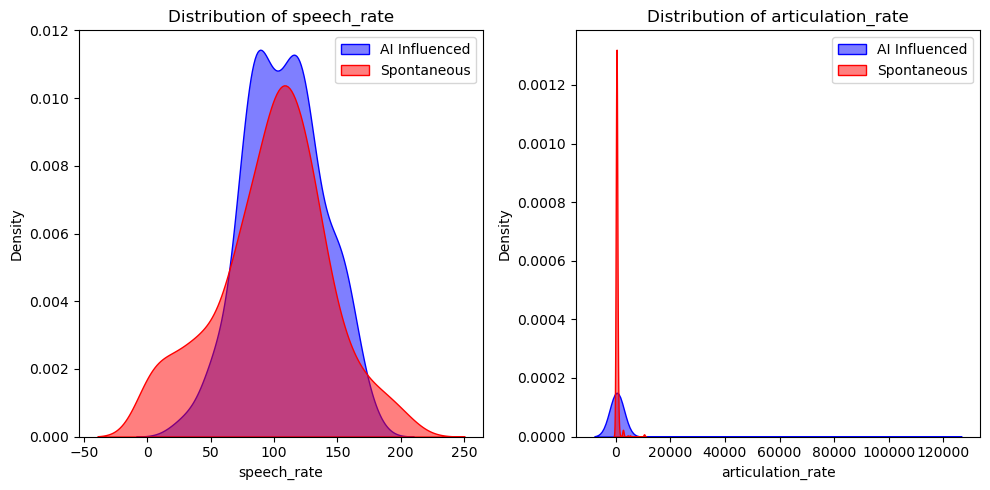

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

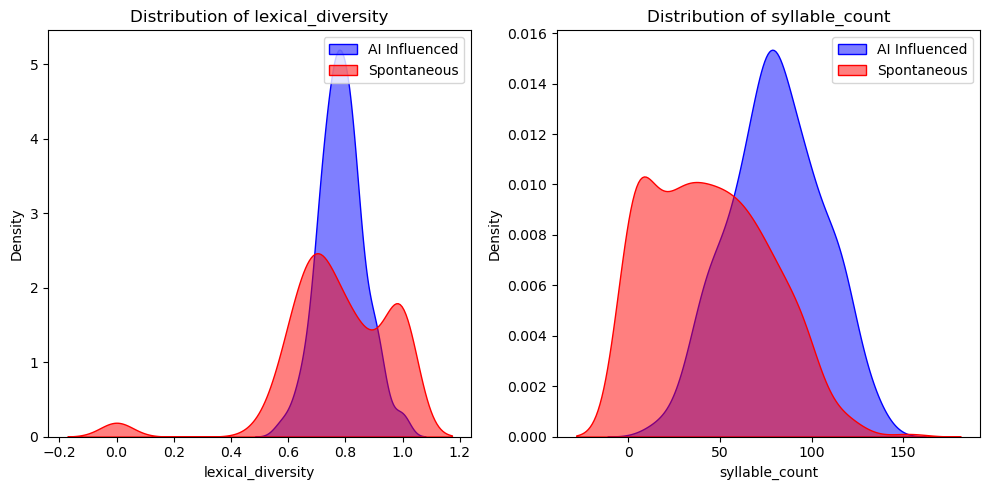

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

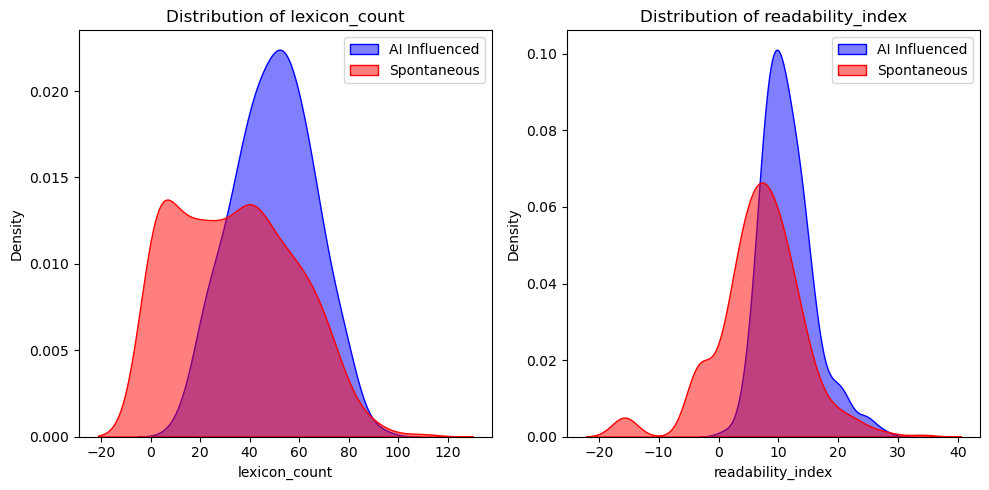

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

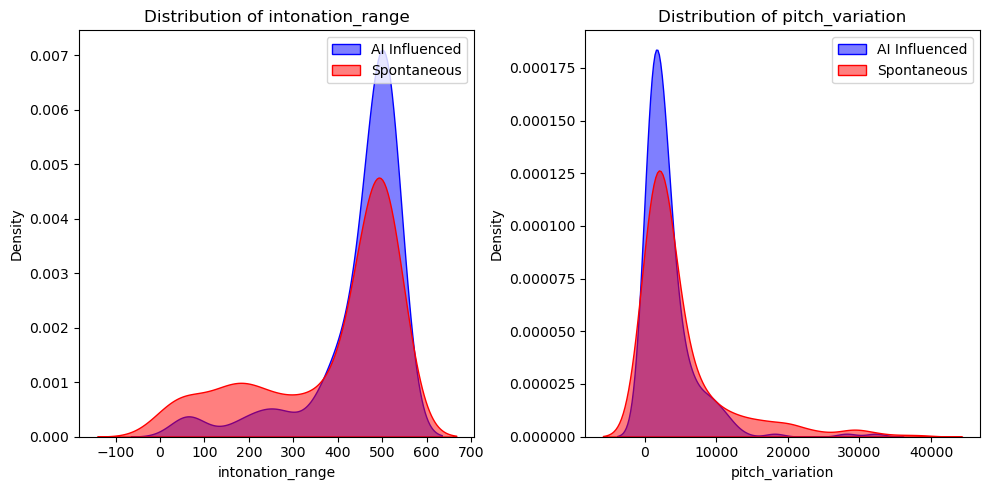

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

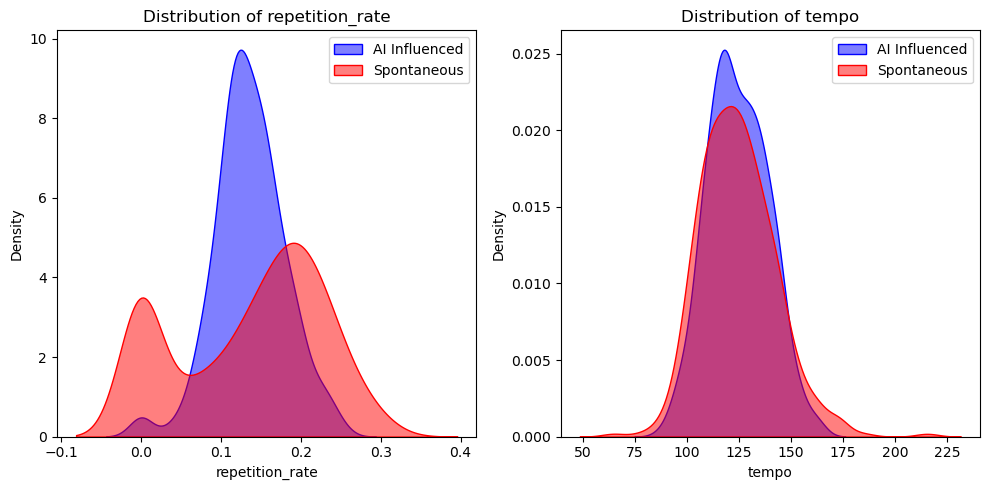

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

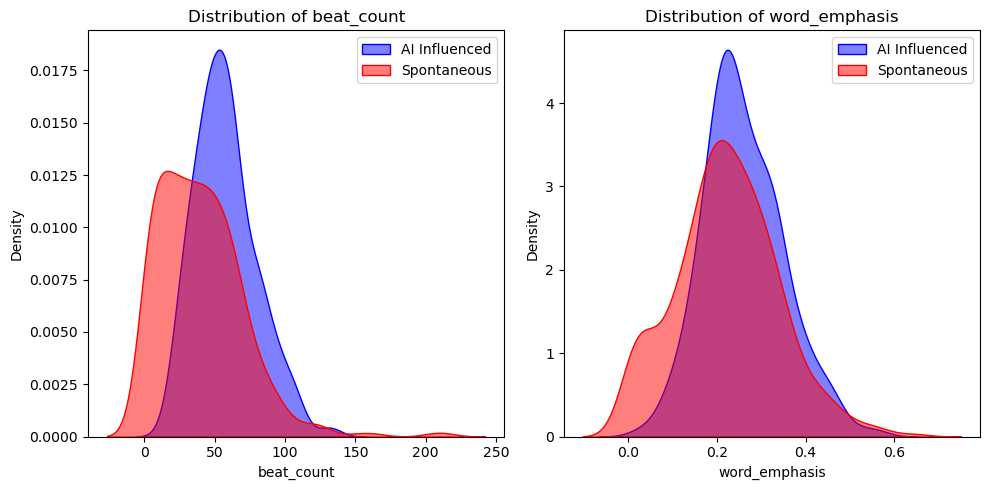

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

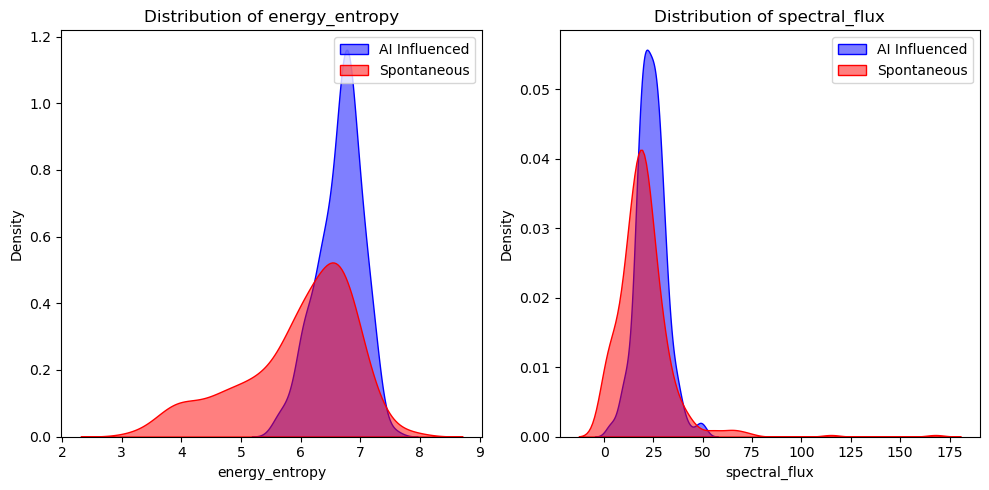

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

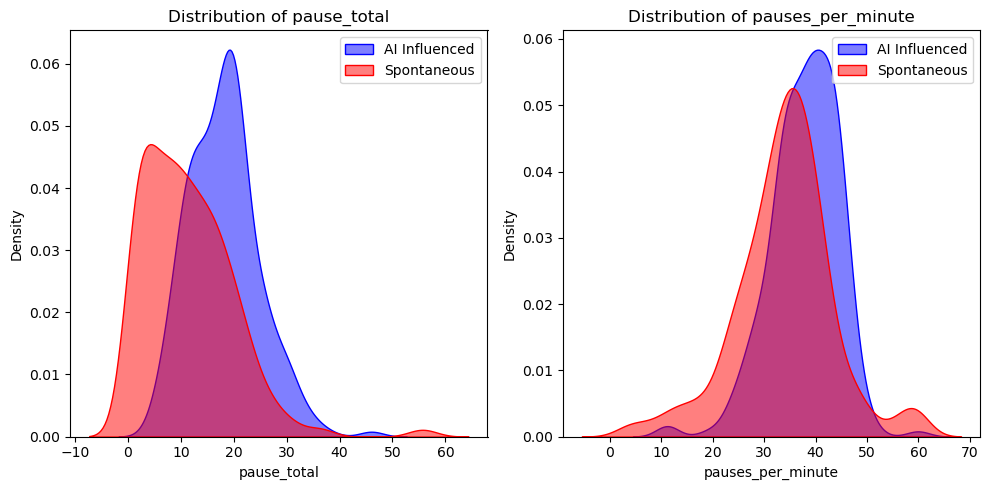

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

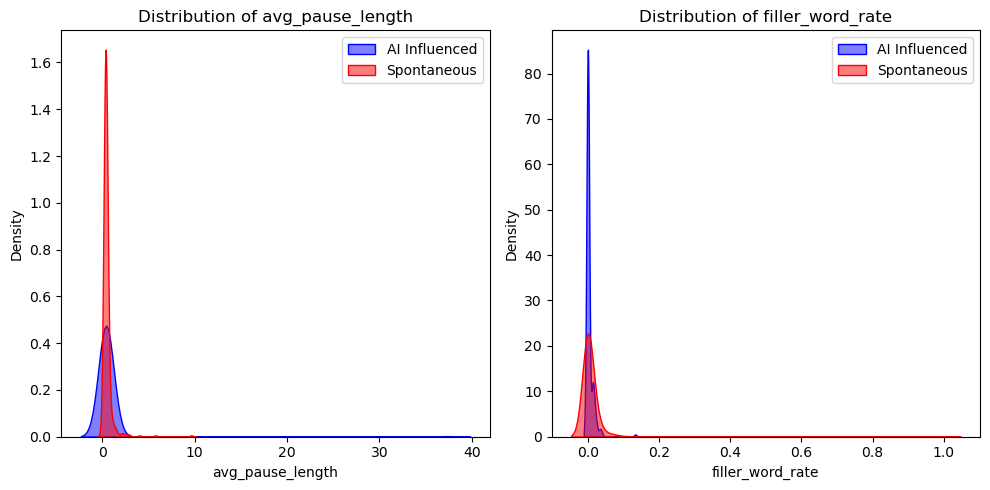

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


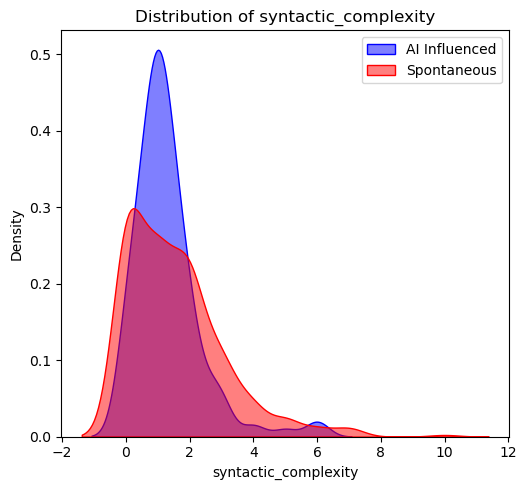

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of features to plot
features = X.columns

# Plot for each feature in pairs (1x2 grids)
i = 0
for j in range(0, len(features), 2):
    plt.figure(figsize=(10, 5))

    # First plot in the pair
    plt.subplot(1, 2, 1)
    sns.kdeplot(x=X[features[j]][y == 1], label="AI Influenced", fill=True, color='blue', alpha=0.5)
    sns.kdeplot(x=X[features[j]][y == 0], label="Spontaneous", fill=True, color='red', alpha=0.5)
    plt.title(f'Distribution of {features[j]}')
    plt.xlabel(features[j])
    plt.ylabel('Density')
    plt.legend()

    # Check if there is a second plot in the pair
    if j + 1 < len(features):
        # Second plot in the pair
        plt.subplot(1, 2, 2)
        sns.kdeplot(x=X[features[j + 1]][y == 1], label="AI Influenced", fill=True, color='blue', alpha=0.5)
        sns.kdeplot(x=X[features[j + 1]][y == 0], label="Spontaneous", fill=True, color='red', alpha=0.5)
        plt.title(f'Distribution of {features[j + 1]}')
        plt.xlabel(features[j + 1])
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"C:\\Users\\shadi\\Desktop\\NCME Proposal\\{i}_{features[j]}.png")
    plt.show()
    i += 1


C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


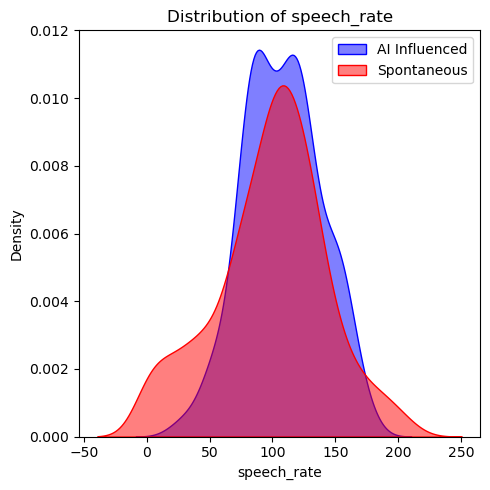

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


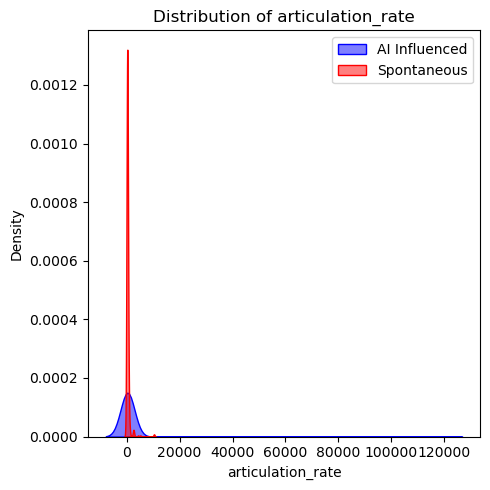

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


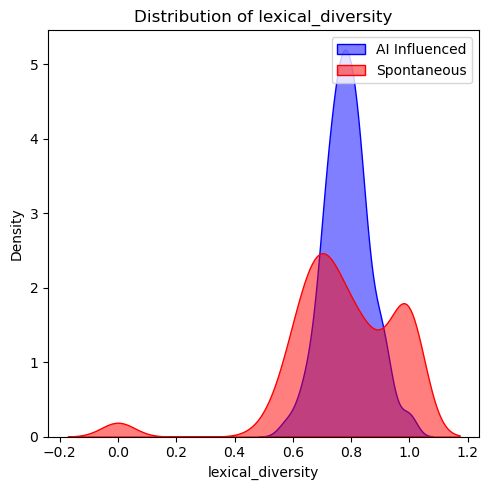

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


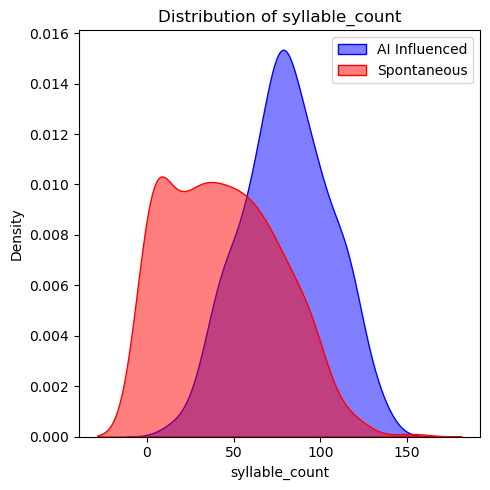

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


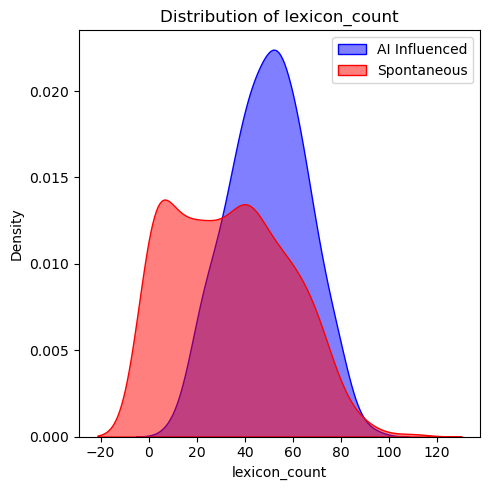

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


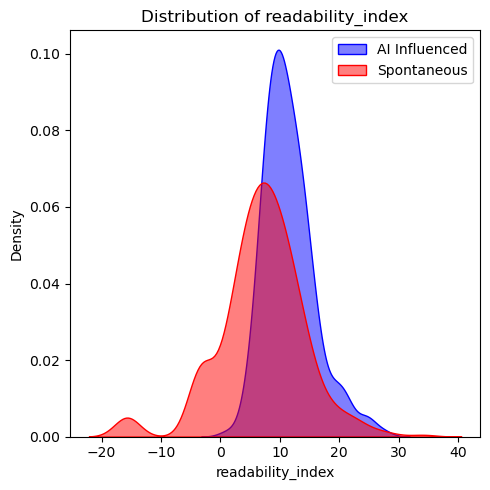

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


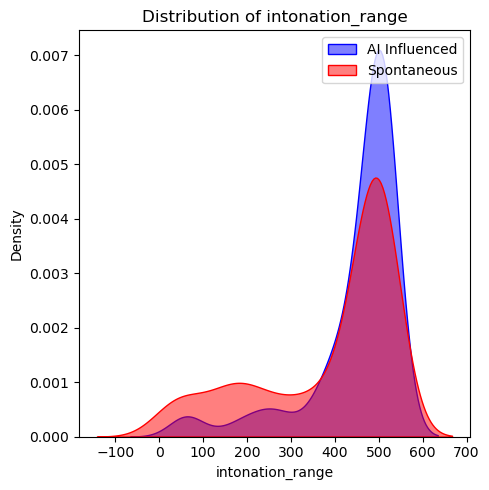

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


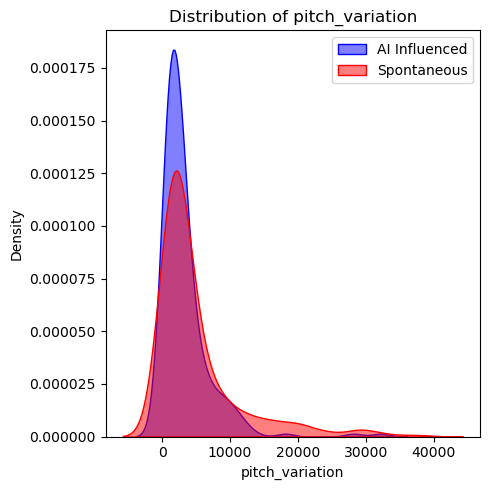

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


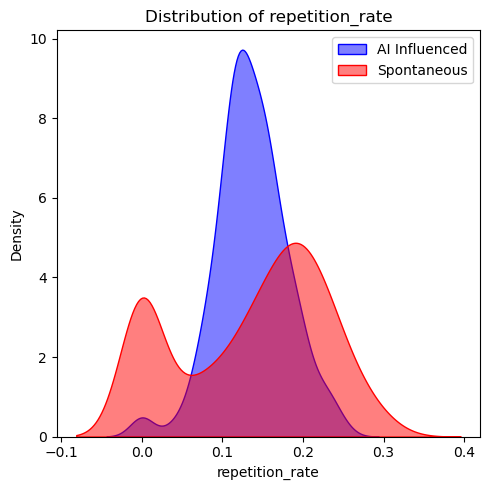

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


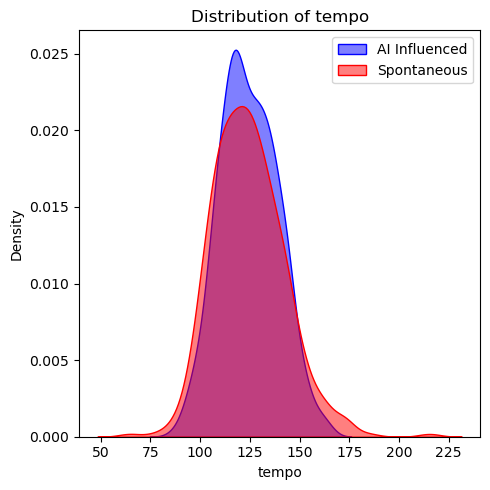

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


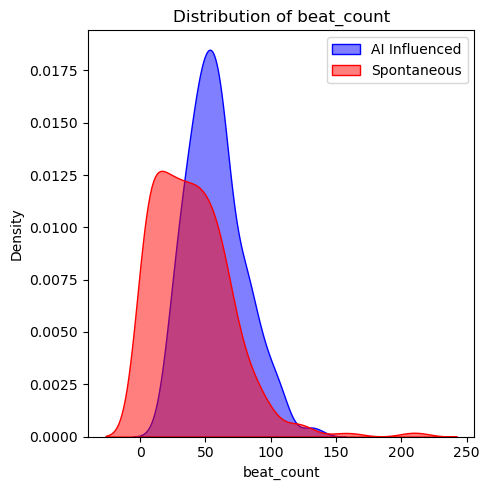

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


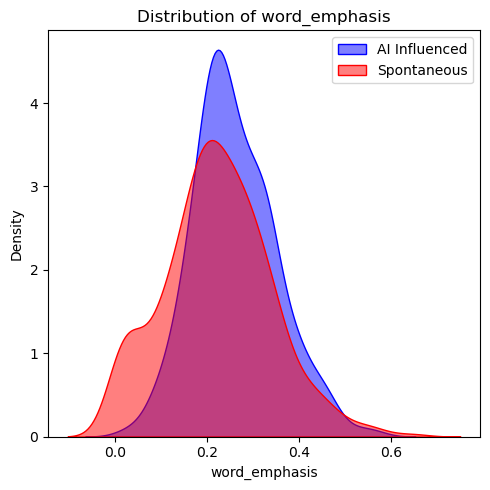

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


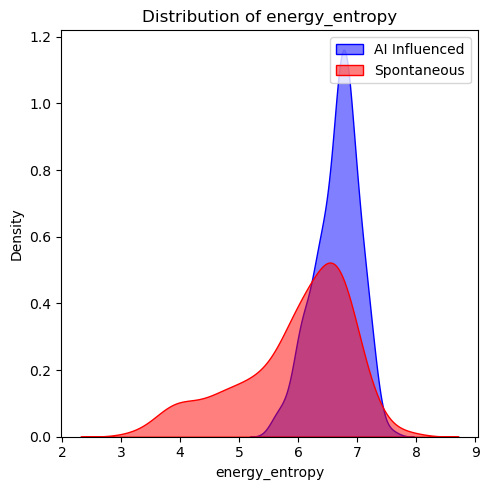

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


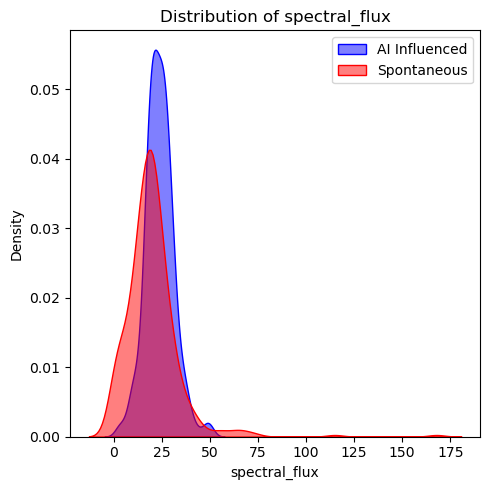

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


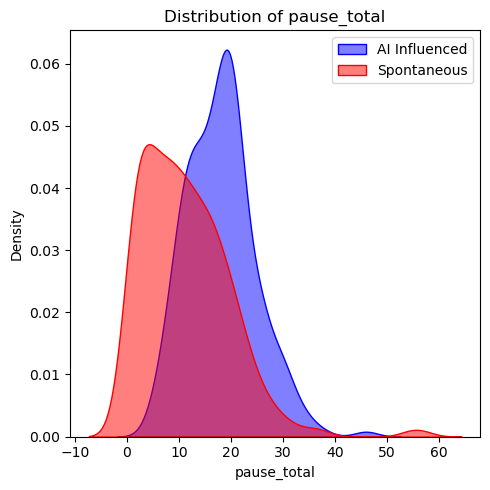

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


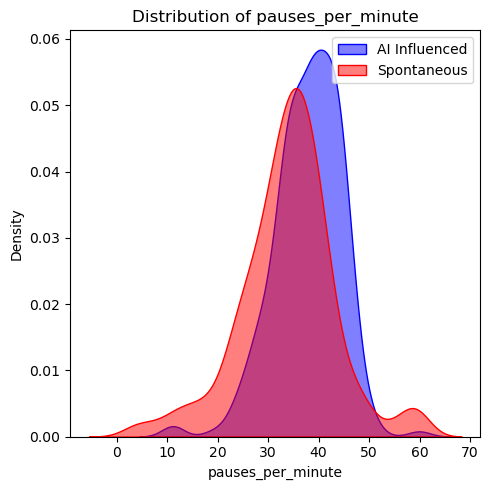

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


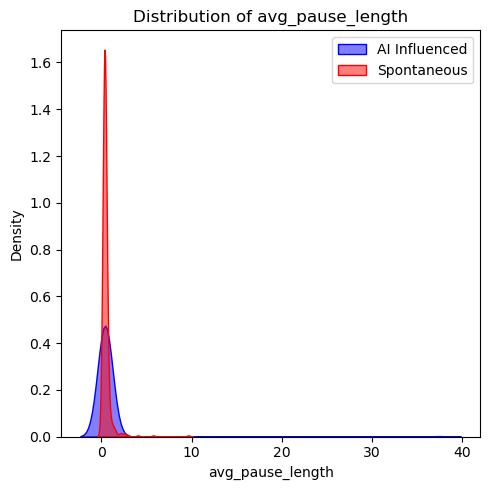

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


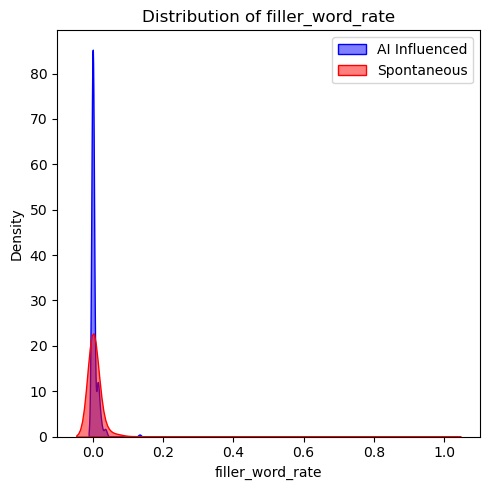

C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shadi\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


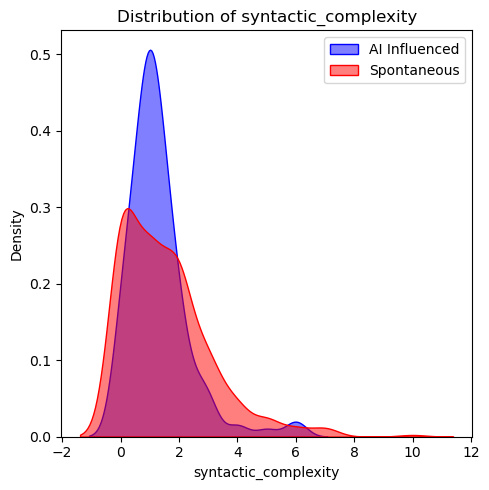

In [ ]:
import seaborn as sns

# List of features to plot
features = X.columns

# Plot for each feature
i = 0
for feature in features:
    plt.figure(figsize=(5, 5))
    sns.kdeplot(x=X[feature][y == 1], label="AI Influenced", fill=True, color='blue', alpha=0.5)
    sns.kdeplot(x=X[feature][y == 0], label="Spontaneous", fill=True, color='red', alpha=0.5)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"C:\\Users\\shadi\\Desktop\\NCME Proposal\\{i}_{feature}.png")
    plt.show()
    i+=1


In the context of the code provided, the tests performed are:

Mean Difference Test: This is done using the two-sample t-test (scipy.stats.ttest_ind). It compares the means of the two groups (label 1 and label 0) for each feature. The p-value from this test is used to determine if the means are significantly different.

Variance Difference Test: This is done using the F-test (scipy.stats.levene), which compares the variances of the two groups (label 1 and label 0) for each feature. The p-value from this test is used to determine if the variances are significantly different.

The significance level is set to 0.05. If the p-value from the test is less than 0.05, it means the mean or variance difference is statistically significant, indicating that the groups (AI Influenced and Spontaneous) have significantly different means or variances for that particular feature.

In [ ]:
from scipy import stats

# Perform t-test for each feature
results = {}
for feature in features:
    group_0 = X[feature][y == 0]
    group_1 = X[feature][y == 1]

    # Calculate means and variances
    mean_0 = group_0.mean()
    mean_1 = group_1.mean()
    var_0 = group_0.var()
    var_1 = group_1.var()

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)

    results[feature] = {
        'Mean Difference': mean_1 - mean_0,
        'Variance Difference': var_1 - var_0,
        'T-Statistic': t_stat,
        'P-Value': p_value
    }

# Convert results to DataFrame
df_results = pd.DataFrame(results).T
df_results = df_results.sort_values(by='P-Value')  # Sort by p-value

# Round off to 3 decimal points and add significance columns
df_results = df_results.round(3)
#df_results['Variance Difference'] = df_results['Variance Difference'].round(2)

# Add significance columns
df_results['Mean Difference Significant'] = df_results['P-Value'] < 0.05
df_results['Variance Difference Significant'] = df_results['P-Value'] < 0.05

df_results


,Mean Difference,Variance Difference,T-Statistic,P-Value,Mean Difference Significant,Variance Difference Significant
syllable_count,35.960,-3.660880e+02,-15.795,0.000,True,True
energy_entropy,0.699,-7.540000e-01,-13.222,0.000,True,True
pause_total,6.748,-2.868300e+01,-11.161,0.000,True,True
lexicon_count,15.841,-3.013100e+02,-10.035,0.000,True,True
readability_index,4.522,-3.275500e+01,-9.984,0.000,True,True
beat_count,17.578,-4.483180e+02,-8.400,0.000,True,True
pauses_per_minute,4.024,-4.695900e+01,-6.321,0.000,True,True
intonation_range,61.188,-1.305537e+04,-5.796,0.000,True,True
word_emphasis,0.038,-5.000000e-03,-4.662,0.000,True,True
spectral_flux,3.788,-1.521000e+02,-4.423,0.000,True,True


In [ ]:
df_results.to_excel(r"C:\Users\shadi\Desktop\NCME Proposal\stat_test.xlsx")

In [ ]:
df['label'].value_counts()

label
0    411
1    229
Name: count, dtype: int64

In [ ]:
len(df)

640

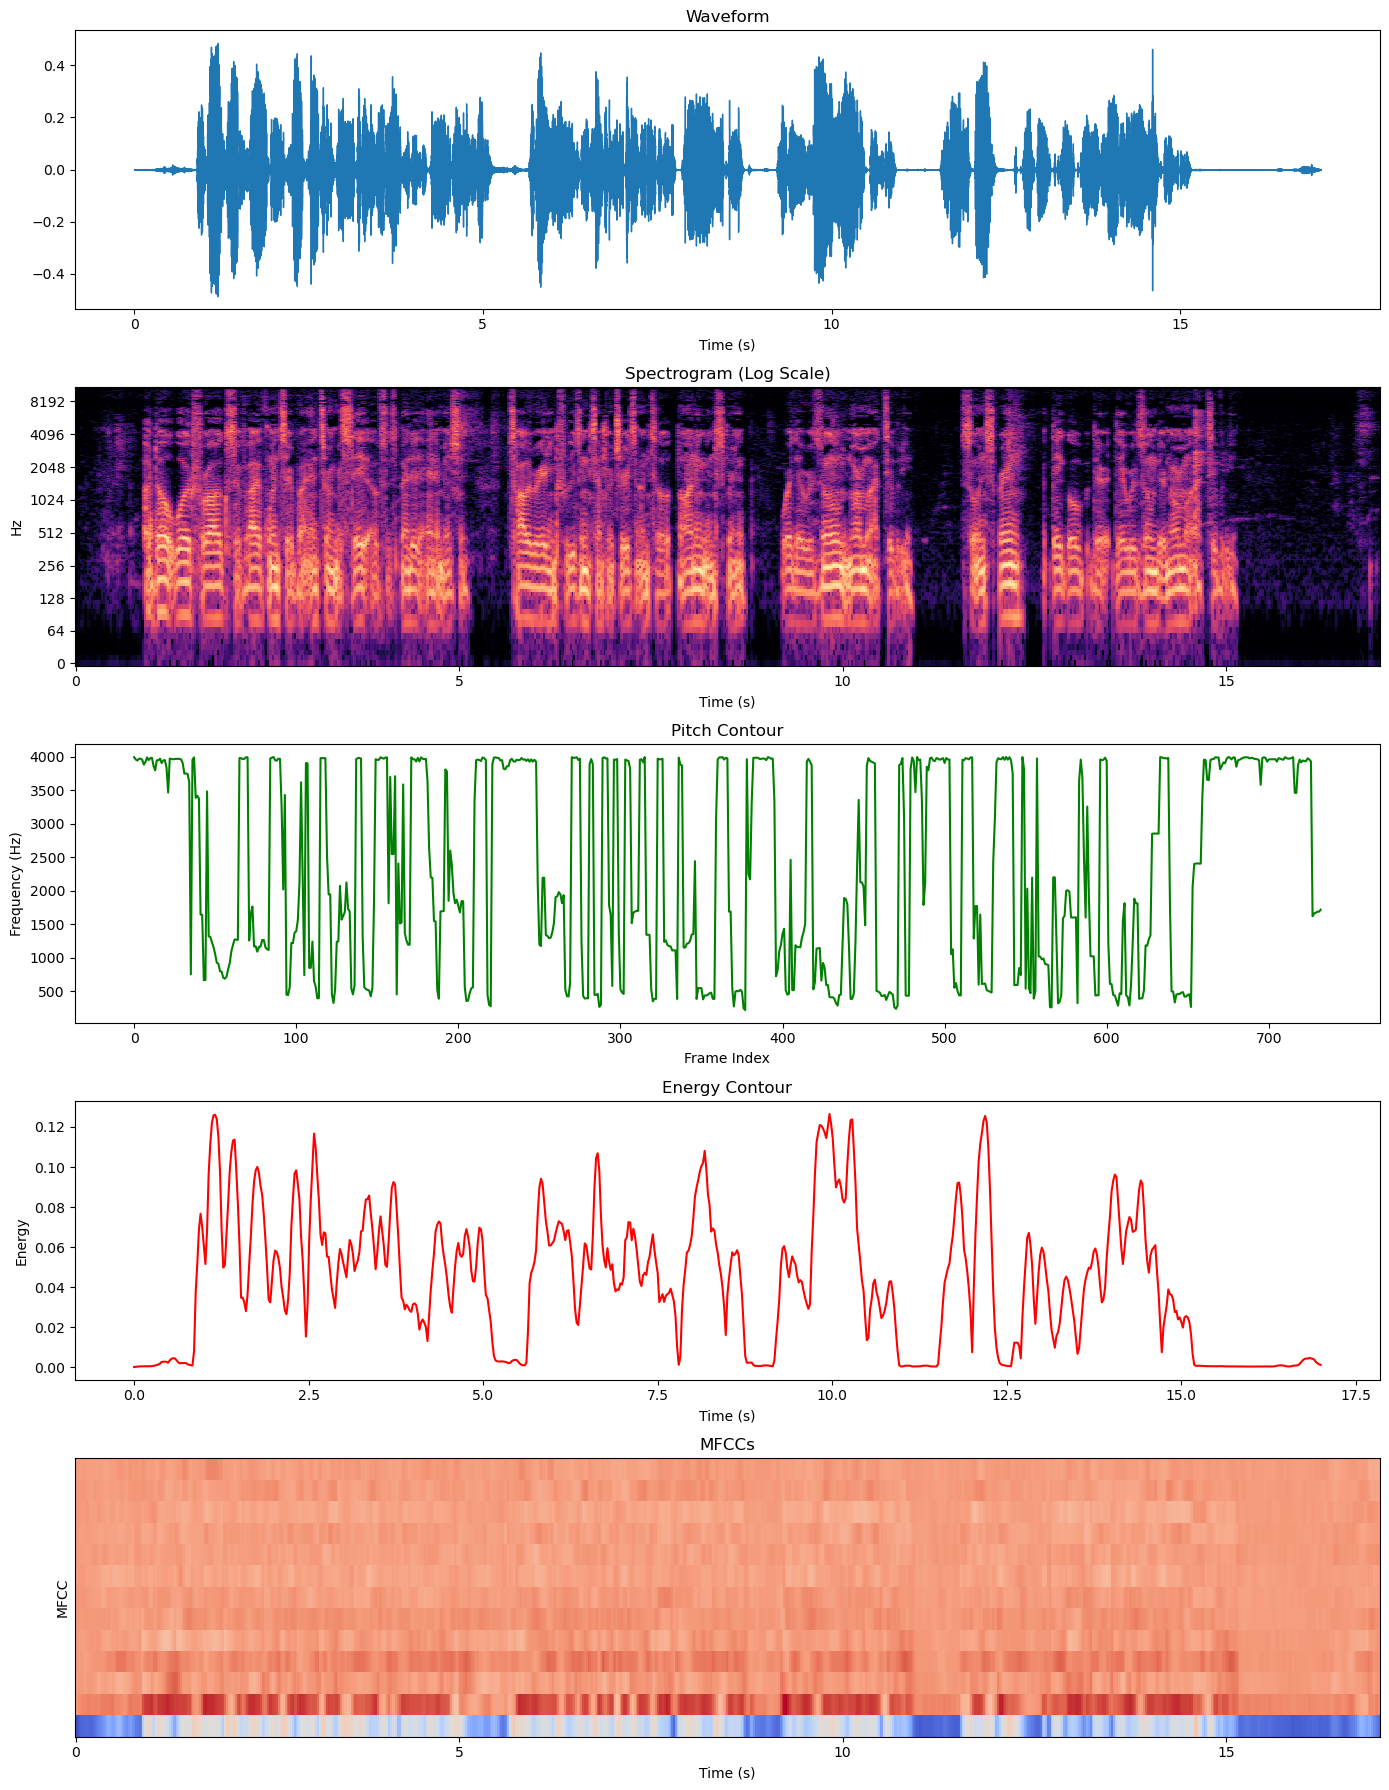

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load an example audio file or replace with your own
audio_path = r"C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\plagiarized_audio\990628278416_20702.wav"  # Replace with your actual file path
y, sr = librosa.load(audio_path)

# Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Pitch
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
pitch_track = np.max(pitches, axis=0)

# Energy
energy = librosa.feature.rms(y=y)[0]
energy_times = librosa.times_like(energy)

# MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(14, 18))

# 1. Waveform
axs[0].set_title("Waveform")
librosa.display.waveshow(y, sr=sr, ax=axs[0])
axs[0].set_xlabel("Time (s)")

# 2. Spectrogram
axs[1].set_title("Spectrogram (Log Scale)")
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=axs[1])
axs[1].set_xlabel("Time (s)")

# 3. Pitch contour
axs[2].set_title("Pitch Contour")
axs[2].plot(pitch_track, color='green')
axs[2].set_ylabel("Frequency (Hz)")
axs[2].set_xlabel("Frame Index")

# 4. Energy contour
axs[3].set_title("Energy Contour")
axs[3].plot(energy_times, energy, color='red')
axs[3].set_ylabel("Energy")
axs[3].set_xlabel("Time (s)")

# 5. MFCCs
axs[4].set_title("MFCCs")
librosa.display.specshow(mfcc, x_axis='time', sr=sr, ax=axs[4])
axs[4].set_ylabel("MFCC")
axs[4].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


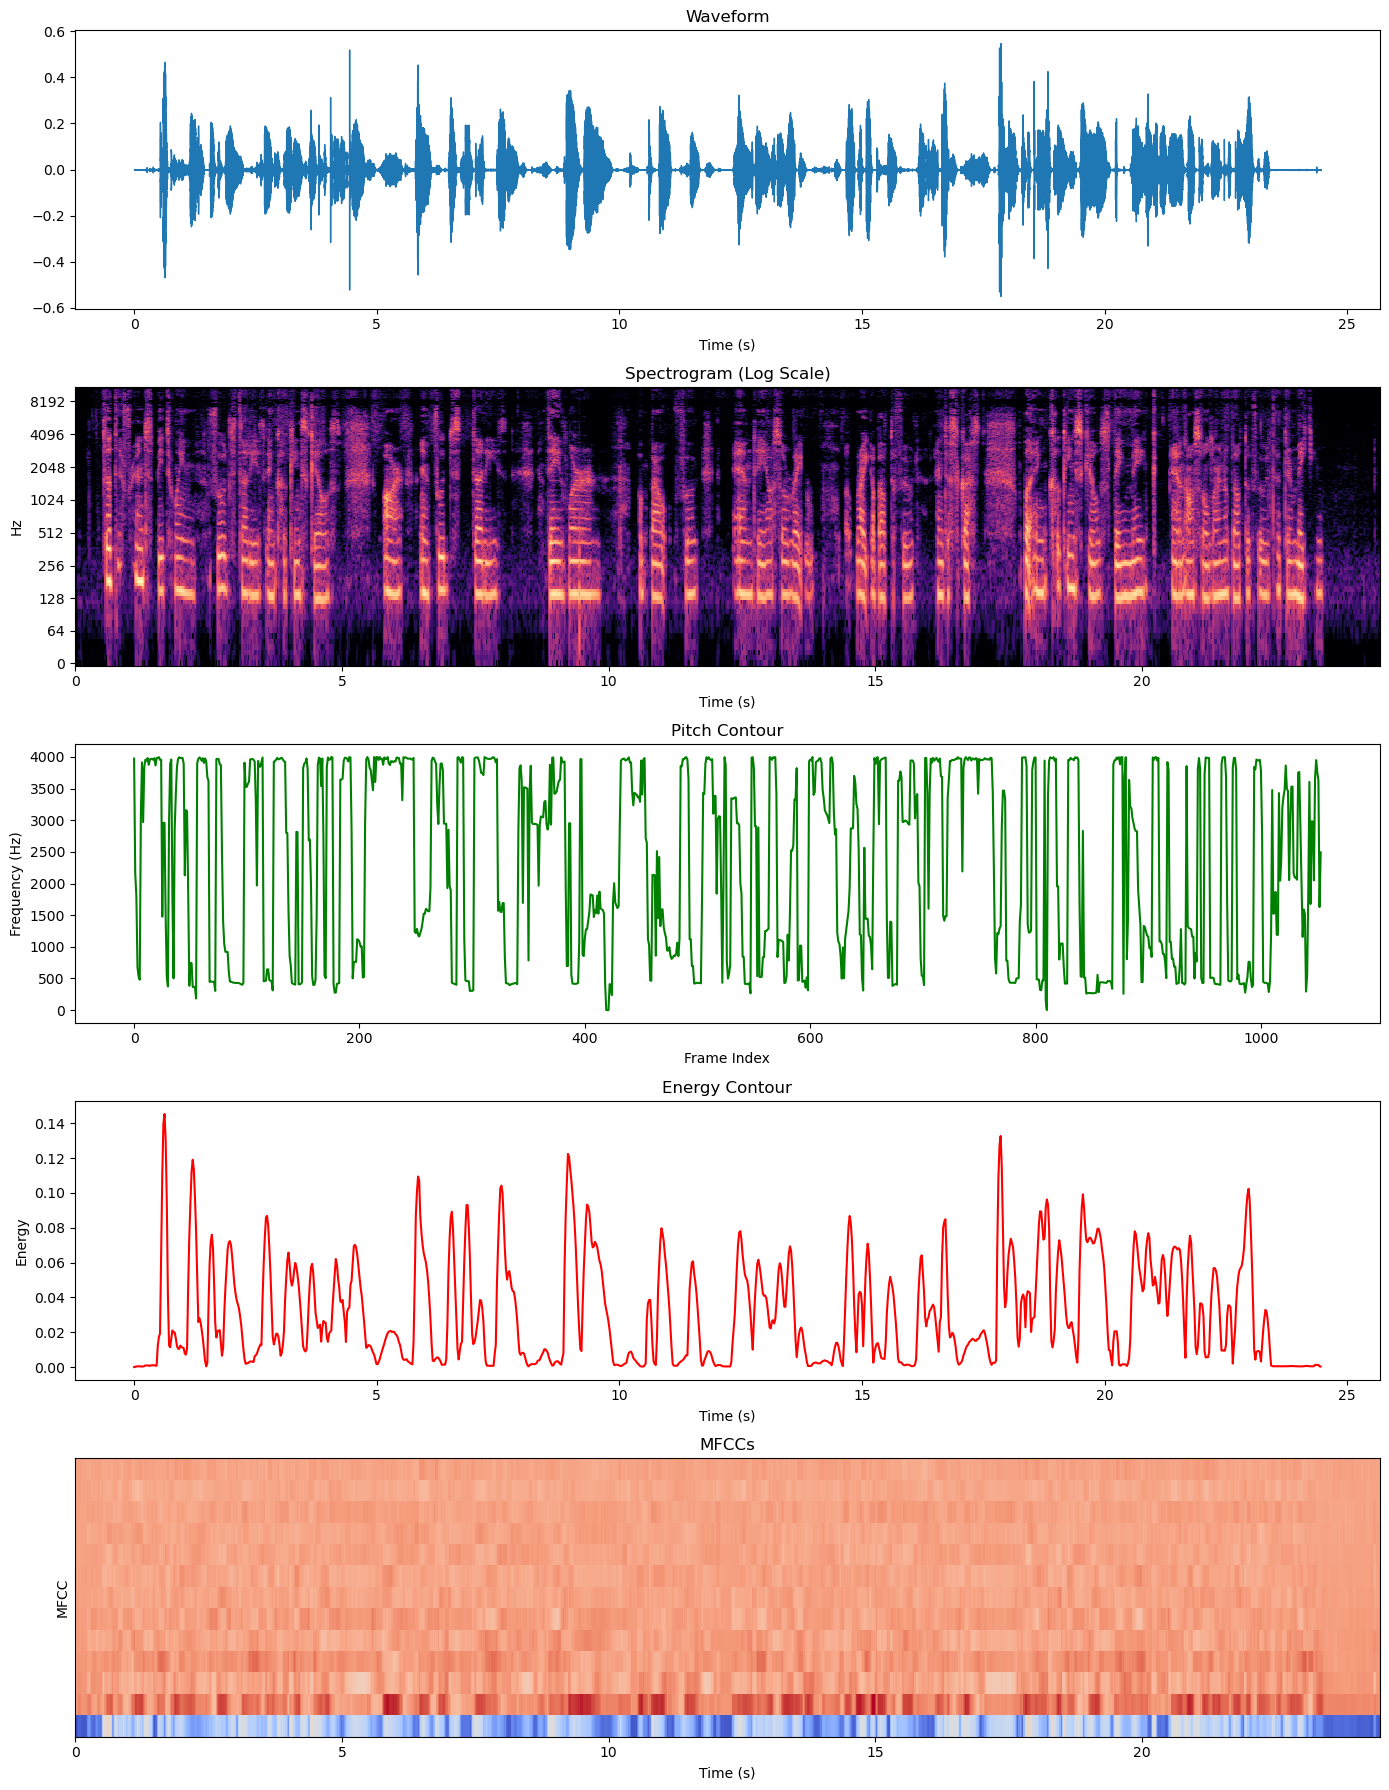

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load an example audio file or replace with your own
audio_path = r"C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\control_audio\990627268286 C91 T_BC 20620 TRS_17 RS_3.wav"  # Replace with your actual file path
y, sr = librosa.load(audio_path)

# Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Pitch
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
pitch_track = np.max(pitches, axis=0)

# Energy
energy = librosa.feature.rms(y=y)[0]
energy_times = librosa.times_like(energy)

# MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(14, 18))

# 1. Waveform
axs[0].set_title("Waveform")
librosa.display.waveshow(y, sr=sr, ax=axs[0])
axs[0].set_xlabel("Time (s)")

# 2. Spectrogram
axs[1].set_title("Spectrogram (Log Scale)")
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=axs[1])
axs[1].set_xlabel("Time (s)")

# 3. Pitch contour
axs[2].set_title("Pitch Contour")
axs[2].plot(pitch_track, color='green')
axs[2].set_ylabel("Frequency (Hz)")
axs[2].set_xlabel("Frame Index")

# 4. Energy contour
axs[3].set_title("Energy Contour")
axs[3].plot(energy_times, energy, color='red')
axs[3].set_ylabel("Energy")
axs[3].set_xlabel("Time (s)")

# 5. MFCCs
axs[4].set_title("MFCCs")
librosa.display.specshow(mfcc, x_axis='time', sr=sr, ax=axs[4])
axs[4].set_ylabel("MFCC")
axs[4].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


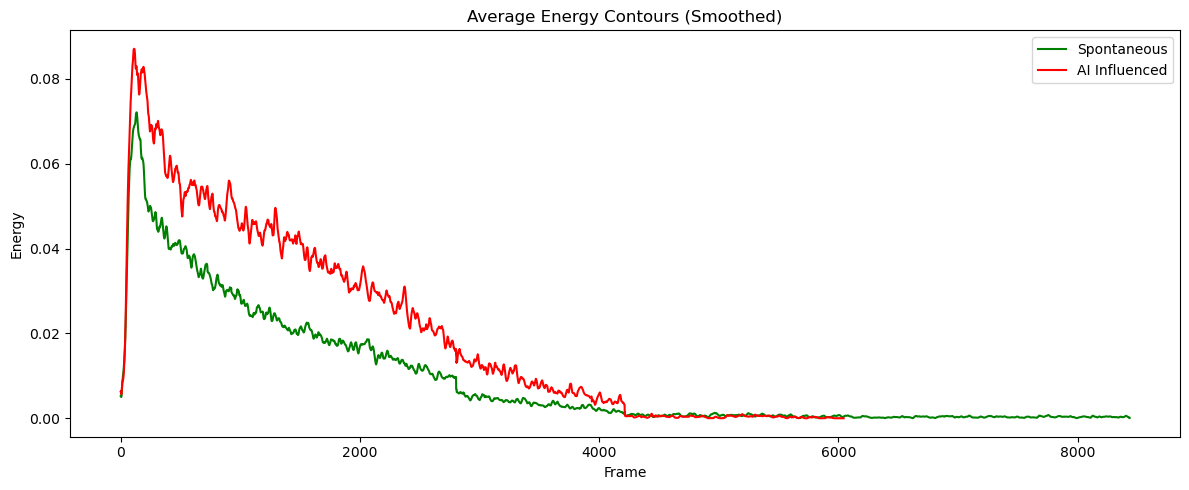

In [ ]:
import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Set these to your actual directories
spontaneous_dir = r"C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\control_audio"
ai_dir = r"C:\Users\shadi\Desktop\SPT Test\Updated Work for NCME\plagiarized_audio"

# Parameters
frame_length = 2048
hop_length = 512
rolling_window = 20  # smoothing factor

def compute_avg_energy_contour(audio_dir):
    energy_contours = []
    for filepath in glob.glob(os.path.join(audio_dir, "*.wav")):
        y, sr = librosa.load(filepath, sr=None)
        energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
        smoothed = uniform_filter1d(energy, size=rolling_window)
        energy_contours.append(smoothed)
    # Pad to the same length
    max_len = max(len(e) for e in energy_contours)
    padded = [np.pad(e, (0, max_len - len(e)), mode='constant') for e in energy_contours]
    mean_energy = np.mean(padded, axis=0)
    return mean_energy

# Compute average contours
spontaneous_avg = compute_avg_energy_contour(spontaneous_dir)
ai_avg = compute_avg_energy_contour(ai_dir)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(spontaneous_avg, label='Spontaneous', color='green')
plt.plot(ai_avg, label='AI Influenced', color='red')
plt.title("Average Energy Contours (Smoothed)")
plt.xlabel("Frame")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()
